In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_hub as hub
import tensorflow_text as text
df_stock = pd.read_csv("icici/ICICIBANK.NS.csv",
                 parse_dates = ["Date"],
                 index_col = ["Date"])
df_posts = pd.read_excel("icici/icici_bank_final_posts.xlsx")
# removing the unnecessary columns
df_posts.drop(["Unnamed: 0"], axis=1,inplace=True)
# removing spam posts
df_posts = df_posts[df_posts.Spam==0.0]
df_posts.drop(["Spam"],axis=1,inplace=True)
# sliding a window of 7 days and adding all the TIs
from stock_helper import prepare_data
x,y = prepare_data(df_stock)
# slicing the data
final_x = x[np.datetime64("2021-11-13"):]
final_y = y[np.datetime64("2021-11-13"):]
# reversing the posts data
df_posts = df_posts[::-1]
final_posts = df_posts[7:]
# loading the sentiment analysis model
sent_model = tf.keras.models.load_model("final_bert")
# removing duplicates from the data
final_posts.drop_duplicates(subset=['Messages'])
# calculating the sentiments score
sentiments = []
prev = np.datetime64("2015-11-12 21:31:26")
for i in final_y.index:
    total=0
    cnt=0
    for j in final_posts.itertuples():
        _,msg,time = j
        if np.datetime64(time)<np.datetime64(i) and np.datetime64(time)>prev:
            total += tf.squeeze(sent_model.predict([msg])).numpy()
            cnt+=1
    prev = np.datetime64(i)
    if(cnt==0):
        sentiments.append(0)
    else:
        sentiments.append(total/cnt)
# getting indices where sentiments score is 0
zero_index = []
for i,j in enumerate(sentiments):
    if(j==0):
        zero_index.append(i)
# removing all the zero values indices
sentiments = np.delete(sentiments,zero_index)
final_x_zeros = final_x.copy()
final_y_zeros = final_y.copy()
final_y_zeros = final_y_zeros.to_frame()
final_x_zeros['removal_assist'] = np.arange(0,len(final_x),1)
final_y_zeros['removal_assist'] = np.arange(0,len(final_x),1)
final_y_zeros = final_y_zeros[final_y_zeros.removal_assist.isin(zero_index)==False]
final_x_zeros = final_x_zeros[final_x_zeros.removal_assist.isin(zero_index)==False]
# removing the added helper column
final_x_zeros.drop(["removal_assist"], axis=1,inplace=True)
final_y_zeros.drop(["removal_assist"], axis=1, inplace=True)

In [2]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
final_x_zeros_scaled = mms.fit_transform(final_x_zeros)
final_x_zeros_scaled

array([[0.46964598, 0.7110796 , 0.830842  , ..., 0.47434157, 0.5546069 ,
        0.7407407 ],
       [0.49432564, 0.72036934, 0.819458  , ..., 0.37842518, 0.53776145,
        0.7037037 ],
       [0.5260892 , 0.73180676, 0.8039284 , ..., 0.33568484, 0.5818709 ,
        0.5925926 ],
       ...,
       [0.9687238 , 0.98316383, 0.7430401 , ..., 0.23337865, 0.32989419,
        0.25925925],
       [0.965055  , 0.9778986 , 0.73816586, ..., 0.21261415, 0.42023087,
        0.25925925],
       [0.96308565, 0.94291973, 0.68118954, ..., 0.34671447, 0.65432334,
        0.25925925]], dtype=float32)

In [3]:
k = final_y_zeros.max()
final_y_zeros= final_y_zeros/k
final_y_zeros

,Close
Date,
2021-11-16,0.926458
2021-11-17,0.923124
2021-11-18,0.925064
2021-11-22,0.911847
2021-11-23,0.911665
2021-11-24,0.921790
2021-11-25,0.910695
2021-11-26,0.875712
2021-11-29,0.871105


In [4]:
model_nbeats = tf.keras.models.load_model("nbeats_icici")
model_nbeats.evaluate(final_x_zeros[43:],final_y_zeros[43:]*k)

1/1 [==============================] - 1s 737ms/step - loss: 10.6543 - mae: 10.6543 - mse: 175.6807


[10.654330253601074, 10.654330253601074, 175.6807098388672]

In [6]:
tf.random.set_seed(42)
inputs = tf.keras.layers.Input(shape=(71))
x = tf.keras.layers.Lambda(lambda x : tf.expand_dims(x,axis=1))(inputs)
x = tf.keras.layers.GRU(128, return_sequences=True)(x)
x = tf.keras.layers.GRU(128, return_sequences=True)(x)
x = tf.keras.layers.GRU(128)(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.models.Model(inputs = inputs, outputs = outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 71)]              0         
                                                                 
 lambda_1 (Lambda)           (None, 1, 71)             0         
                                                                 
 gru_3 (GRU)                 (None, 1, 128)            77184     
                                                                 
 gru_4 (GRU)                 (None, 1, 128)            99072     
                                                                 
 gru_5 (GRU)                 (None, 128)               99072     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 275,457
Trainable params: 275,457
Non-trainab

In [7]:
model.compile(loss="mae",optimizer = tf.keras.optimizers.Adam(), metrics=["mae","mse"])
history = model.fit(final_x_zeros_scaled[:43],final_y_zeros[:43],
                    epochs = 1000,
                    validation_data = (final_x_zeros_scaled[43:], final_y_zeros[43:]),
                   callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                                        patience=200, 
                                                        restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", 
                                                           patience=100, 
                                                           verbose=1)])

Epoch 1/1000
2/2 [==============================] - 7s 685ms/step - loss: 0.8963 - mae: 0.8963 - mse: 0.8061 - val_loss: 0.7132 - val_mae: 0.7132 - val_mse: 0.5108 - lr: 0.0010
Epoch 2/1000
2/2 [==============================] - 0s 41ms/step - loss: 0.6977 - mae: 0.6977 - mse: 0.4920 - val_loss: 0.3602 - val_mae: 0.3602 - val_mse: 0.1373 - lr: 0.0010
Epoch 3/1000
2/2 [==============================] - 0s 43ms/step - loss: 0.4420 - mae: 0.4420 - mse: 0.2142 - val_loss: 0.1487 - val_mae: 0.1487 - val_mse: 0.0365 - lr: 0.0010
Epoch 4/1000
2/2 [==============================] - 0s 43ms/step - loss: 0.2102 - mae: 0.2102 - mse: 0.0628 - val_loss: 0.7173 - val_mae: 0.7173 - val_mse: 0.5448 - lr: 0.0010
Epoch 5/1000
2/2 [==============================] - 0s 41ms/step - loss: 0.3135 - mae: 0.3135 - mse: 0.1895 - val_loss: 0.7078 - val_mae: 0.7078 - val_mse: 0.5259 - lr: 0.0010
Epoch 6/1000
2/2 [==============================] - 0s 41ms/step - loss: 0.2864 - mae: 0.2864 - mse: 0.1559 - val_loss:

2/2 [==============================] - 0s 32ms/step - loss: 0.0129 - mae: 0.0129 - mse: 2.6077e-04 - val_loss: 0.0153 - val_mae: 0.0153 - val_mse: 3.7214e-04 - lr: 0.0010
Epoch 47/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0104 - mae: 0.0104 - mse: 1.8462e-04 - val_loss: 0.0160 - val_mae: 0.0160 - val_mse: 4.7402e-04 - lr: 0.0010
Epoch 48/1000
2/2 [==============================] - 0s 33ms/step - loss: 0.0099 - mae: 0.0099 - mse: 1.8377e-04 - val_loss: 0.0097 - val_mae: 0.0097 - val_mse: 1.9931e-04 - lr: 0.0010
Epoch 49/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0109 - mae: 0.0109 - mse: 2.1731e-04 - val_loss: 0.0138 - val_mae: 0.0138 - val_mse: 3.3292e-04 - lr: 0.0010
Epoch 50/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0118 - mae: 0.0118 - mse: 2.9242e-04 - val_loss: 0.0155 - val_mae: 0.0155 - val_mse: 2.8030e-04 - lr: 0.0010
Epoch 51/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0133 - mae: 0

Epoch 91/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0233 - mae: 0.0233 - mse: 6.5873e-04 - val_loss: 0.0246 - val_mae: 0.0246 - val_mse: 8.3901e-04 - lr: 0.0010
Epoch 92/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0209 - mae: 0.0209 - mse: 4.8921e-04 - val_loss: 0.0189 - val_mae: 0.0189 - val_mse: 5.1188e-04 - lr: 0.0010
Epoch 93/1000
2/2 [==============================] - 0s 32ms/step - loss: 0.0097 - mae: 0.0097 - mse: 1.6488e-04 - val_loss: 0.0172 - val_mae: 0.0172 - val_mse: 4.0870e-04 - lr: 0.0010
Epoch 94/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0104 - mae: 0.0104 - mse: 1.4276e-04 - val_loss: 0.0180 - val_mae: 0.0180 - val_mse: 4.4756e-04 - lr: 0.0010
Epoch 95/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0078 - mae: 0.0078 - mse: 1.2371e-04 - val_loss: 0.0165 - val_mae: 0.0165 - val_mse: 3.7782e-04 - lr: 0.0010
Epoch 96/1000
2/2 [==============================] - 0s 30ms/step - loss: 0

2/2 [==============================] - 0s 37ms/step - loss: 0.0058 - mae: 0.0058 - mse: 5.8546e-05 - val_loss: 0.0185 - val_mae: 0.0185 - val_mse: 5.4730e-04 - lr: 0.0010
Epoch 136/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0099 - mae: 0.0099 - mse: 1.4442e-04 - val_loss: 0.0147 - val_mae: 0.0147 - val_mse: 3.1797e-04 - lr: 0.0010
Epoch 137/1000
2/2 [==============================] - 0s 32ms/step - loss: 0.0128 - mae: 0.0128 - mse: 1.7680e-04 - val_loss: 0.0229 - val_mae: 0.0229 - val_mse: 7.4863e-04 - lr: 0.0010
Epoch 138/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0119 - mae: 0.0119 - mse: 1.7213e-04 - val_loss: 0.0143 - val_mae: 0.0143 - val_mse: 2.6608e-04 - lr: 0.0010
Epoch 139/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0072 - mae: 0.0072 - mse: 7.2471e-05 - val_loss: 0.0204 - val_mae: 0.0204 - val_mse: 6.2726e-04 - lr: 0.0010
Epoch 140/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0068 - m

Epoch 178/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0032 - mae: 0.0032 - mse: 3.2274e-05 - val_loss: 0.0160 - val_mae: 0.0160 - val_mse: 3.5298e-04 - lr: 1.0000e-04
Epoch 179/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0031 - mae: 0.0031 - mse: 3.2977e-05 - val_loss: 0.0165 - val_mae: 0.0165 - val_mse: 3.9565e-04 - lr: 1.0000e-04
Epoch 180/1000
2/2 [==============================] - 0s 33ms/step - loss: 0.0033 - mae: 0.0033 - mse: 3.7139e-05 - val_loss: 0.0160 - val_mae: 0.0160 - val_mse: 3.4607e-04 - lr: 1.0000e-04
Epoch 181/1000
2/2 [==============================] - 0s 32ms/step - loss: 0.0033 - mae: 0.0033 - mse: 3.3739e-05 - val_loss: 0.0159 - val_mae: 0.0159 - val_mse: 3.3348e-04 - lr: 1.0000e-04
Epoch 182/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0032 - mae: 0.0032 - mse: 3.4165e-05 - val_loss: 0.0163 - val_mae: 0.0163 - val_mse: 3.6829e-04 - lr: 1.0000e-04
Epoch 183/1000
2/2 [==============================

2/2 [==============================] - 0s 30ms/step - loss: 0.0031 - mae: 0.0031 - mse: 3.3818e-05 - val_loss: 0.0166 - val_mae: 0.0166 - val_mse: 3.6194e-04 - lr: 1.0000e-04
Epoch 222/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0030 - mae: 0.0030 - mse: 3.1472e-05 - val_loss: 0.0175 - val_mae: 0.0175 - val_mse: 4.4616e-04 - lr: 1.0000e-04
Epoch 223/1000
2/2 [==============================] - 0s 31ms/step - loss: 0.0038 - mae: 0.0038 - mse: 4.2028e-05 - val_loss: 0.0172 - val_mae: 0.0172 - val_mse: 4.1536e-04 - lr: 1.0000e-04
Epoch 224/1000
2/2 [==============================] - 0s 29ms/step - loss: 0.0030 - mae: 0.0030 - mse: 3.5120e-05 - val_loss: 0.0163 - val_mae: 0.0163 - val_mse: 3.4146e-04 - lr: 1.0000e-04
Epoch 225/1000
2/2 [==============================] - 0s 30ms/step - loss: 0.0034 - mae: 0.0034 - mse: 3.1977e-05 - val_loss: 0.0171 - val_mae: 0.0171 - val_mse: 4.0563e-04 - lr: 1.0000e-04
Epoch 226/1000
2/2 [==============================] - 0s 31ms/ste

In [8]:
preds = tf.squeeze(model.predict(final_x_zeros_scaled[43:])).numpy()
preds = preds*k.values[0]
preds

array([794.7976 , 796.802  , 789.7172 , 794.16956, 808.69275, 816.62695,
       805.85   , 797.77545, 763.6633 , 782.0082 , 791.0225 ],
      dtype=float32)

In [10]:
mae = sum(abs(preds-(tf.squeeze(final_y_zeros[43:].to_numpy()).numpy())*k.values[0]))
mae

87.65093994140625

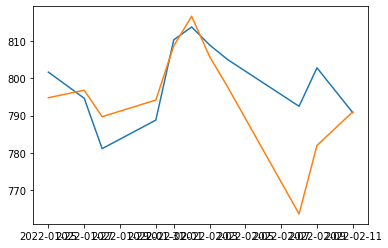

In [12]:
plt.plot(final_y_zeros.index[43:], (tf.squeeze(final_y_zeros[43:].to_numpy()).numpy())*k.values[0])
plt.plot(final_y_zeros.index[43:], preds)

In [13]:
model.save("GRU_icici")

INFO:tensorflow:Assets written to: GRU_icici\assets


INFO:tensorflow:Assets written to: GRU_icici\assets
